In [18]:
#just importing packages

from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

This notebook demonstrates how we are using Fourier transforms to analyze information contained in exoplanetary spectra. We begin with an example with a known Fourier transform to illustrate what Python's fast Fourier transform is doing. 

Take the composite function 
$$f(x) = sin(50 \times 2\pi x) + \frac{1}{2} sin(80 \times 2\pi x).$$

We create a linearly spaced array of N x-values from 0 to N*dx for dx the space between samples. We then apply our f(x) to this array to create an array with indices corresponding to the entries in the x-array. 

The Fast Fourier transform 

$$F(k) = \sum_{x=0}^{N-1} e^{-2\pi i \frac{kx}{N}}f(x)$$

should then give two spikes at frequencies of k=50 and k=80, corresponding to the frequencies of the two sines. The amplitude of the peak at k=80 should be smaller because it has a smaller amplitude in f(x). 

We apply Python's SciPy (Scientifiy Python) real FFT routine, rfft, on the f(x) array. For the frequencies, we use a real FFT frequency routine, rfftfreq. The Fourier transform treats the data as periodic with a fundamental period equal to the range of x - here, N*dx. The fundamental frequency is then the inverse of the fundamental period, or

$$f_{fundamental} = \frac{1}{NT}.$$

This rfftfreqq routine gives an array of frequency bins that are integer multiples of this fundamental frequency from 0 to N-1, so

$$RFFTfreq = \frac{n}{NT}, \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  n=0,1,2,...,N-1.$$ 
As shown below, this gives the expected result.

Text(0.5, 1.0, 'Fourier transform of two sine waves')

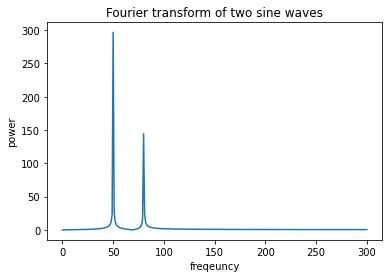

In [2]:
# Number of sample points
N = 600
# sample spacing
dx = 1/600#1e-3#1/800

#create x-array from 0 to N*T with N points
x = np.linspace(0.0, N*dx, N)
#create f(x) array
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)

#take Fourier transform of f(x)
yf = rfft(y)
#Fourier transform frequency
xf = rfftfreq(N, dx)


plt.plot(xf, np.abs(yf))
plt.xlabel('freqeuncy')
plt.ylabel('power')
plt.title('Fourier transform of two sine waves')

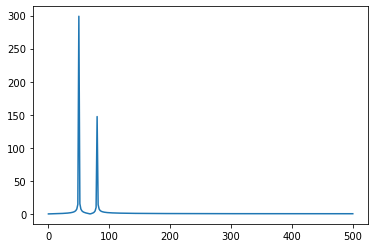

In [73]:
#Here's a demo showing what the x-axis array is - it's integer multiples of the fundamental frequency
xf_test = np.linspace(0,1/(2*dx),int(N/2)+1)
plt.plot(xf_test,np.abs(yf))


# Exoplanet

Now we want to do the same analysis with an exoplanet spectrum. Shown below is the spectrum of Earth. I've labeled some of the strongest absorption lines with dashed lines and would like to be able to label them in the Fourier transformed-version as well. 

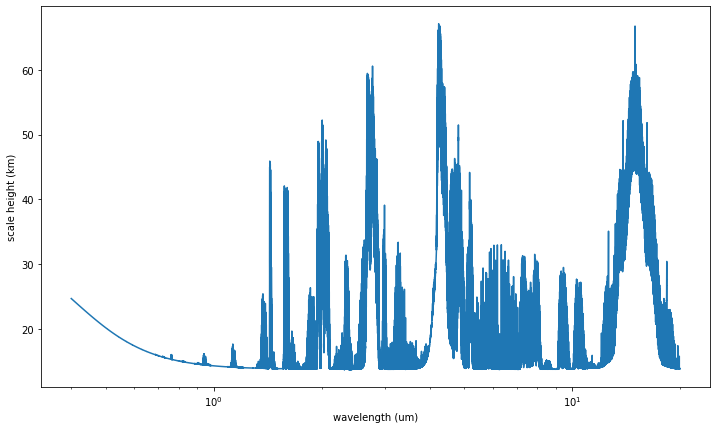

In [7]:
#load transit depth and wavelengths for Earth
#earth_wave, earth_trans = np.loadtxt('/Users/saravannah/betelgeuse/reduced_spectra/reduced_transit_spectra_Sun_0.0Ga.txt', unpack=True, skiprows=2)

earth_wave, earth_trans = np.loadtxt('/Users/saravannah/Desktop/Transit_spectra_data/Transit_spectra_FGKM_stars_through_time_Sun_3.9Ga.txt', unpack=True, skiprows=2)

plt.plot(earth_wave, earth_trans)

plt.xscale('log')

plt.xlabel('wavelength (um)')
plt.ylabel('scale height (km)')

plt.gcf().set_size_inches(12, 7)



Below, I show the Fourier transform of this exoplanet spectrum using the same method as used for the sum of sine waves. 

Text(0.5, 1.0, 'Fourier transform of Earth spectrum')

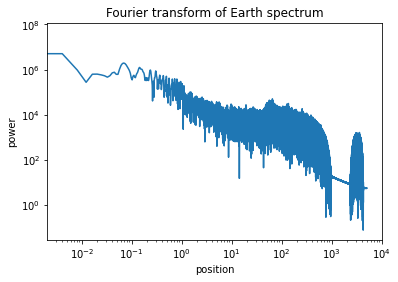

In [8]:
#number of sample points in array
N = len(earth_trans)
dx = 1e-4

#take Fourier transform of transit depth array
yf = rfft(earth_trans)
#get Fourier transform "frequency" (here, wavenumber instead of frequency)
xf = rfftfreq(N, dx)

plt.plot(xf, np.abs(yf))

plt.yscale('log')
plt.xscale('log')
plt.xlabel('position (um)')
plt.ylabel('power')
plt.title('Fourier transform of Earth spectrum')

# Problem:

Note the x-axis of the plot is position, not wavenumber. The Fourier frequency analog in this case is position. In order to find $D_{JS}$ density (and thus the Fourier transform) at particular wavelengths/wavenumbers - say, at a wavelength corresponding to H$_2$O - I need a way to convert position to wavenumber. Unfortunately, this isn't possible. Firstly, the position array and the inversion of the wavelength array (that is, the array created by taking 1/wavelength) have neither the same range nor the same number of points. The position array goes from 0 to the $\frac{1}{2 d\lambda}$, while the wavenumber array would go from $\frac{1}{\lambda_{min}}$ to $\frac{1}{\lambda_{max}}$. The position array has $\frac{N}{2}+1$ points, while the wavenumber array has N points. 

In theory, it is possible to find a spacing $d\lambda$ for which the ranges of the two arrays would be the same. Unfortunately, the $d\lambda$ required for our dataset is far too large. This is derived in the attached notes. Furthermore, the two arrays would not have the same resolution (one would still have $\frac{N}{2}+1$ points while the other would have $N$). There may not be points in the $d\lambda$ array that corresponds to a every point in the position array.



Our method makes the assumption that we can find the Fourier transform at every point in the wavelength spectrum. This isn't true. The discrete Fourier transform is a sum over all the wavelengths in the array, given by 

$$\hat{H}(x_n) = \sum^{N-1}_{n=0}H(\lambda_n) e^{2\pi n x / N}$$

for $H(\lambda_n)$ the the scale height at a particular wavelength and $\hat{H}$ the Fourier transform of $H$, so we cannot get $\hat{H}(\lambda_n)$ unless we have a way to convert $\lambda_n$ (or $\frac{1}{\lambda_n}$) to $x_n$. 


# Solution?

Why do we need to take the Fourier transform of the spectrum in the first place? The spectrum itself is a Fourier transform - it was created by light streaming through a spectrograph, separating the waves into their Fourier components. This gives the power at each wavenumber, just like we had for each mode in the CMB power spectrum. By taking the Fourier transform of our spectrum, we were essentially undoing the Fourier transform - moving us back into real space. What if, instead, we treated the spectrum that we have (e.g. from Lisa's data) as the Fourier transform we're looking for, and conducted the $D_{JS}$ analysis based on this? 

This analysis is presented below. We compute the Djs relative to our modern Earth through different evolutionary stages and for different star-planet systems. We also compute the Djs density and label several key molecular transitions.

In [47]:
#This cell is the Djs calculation

def get_djs(spec1):
    
    #spectrum you're comparing to
    #(note this is bad coding practice - I know, should be more modular but this is *much* easier)
    spec2 = earth

    #compute modal fractions
    p, q = spec1/sum(spec1), spec2/sum(spec2)
    r = 1/2 * (p+q)
    
    Djs = 1/2 * np.sum(p*np.log(p/r)) + 1/2 * np.sum(q*np.log(q/r))
    
    return Djs

In [13]:
#This cell sets up and imports Lisa's data
#You can skip over reading this cell and the next one - nothing interesting here

path = '/Users/saravannah/Desktop/Transit_spectra_data/'
from os import listdir
names = listdir(path)

prefix = 'Transit_spectra_FGKM_stars_through_time_'
suffix = '.txt'

#stars in Kaltenegger data in order from hottest to coldest
stars = ['F0V', 'F7V', 'Sun', 'G8V', 'K2V', 'K7V', 'M1A', 'M3A', 'M8A']
#ages of earth in Kaltenegger data
ages = ['0.0Ga', '0.8Ga', '2.0Ga', '3.9Ga']

#this takes ~13.5 min - be patient!
spectra = {star:[np.loadtxt(path+prefix+star+'_'+age+suffix, unpack=True, skiprows=1)[1] for age in ages] for star in stars}

In [48]:
#This cell is just doing some housekeeping - changing data structures and calculating Djs for each planet

waves = np.loadtxt(path+'Transit_spectra_FGKM_stars_through_time_Sun_3.9Ga.txt', unpack=True, skiprows=1)[0]
spectra_df = pd.DataFrame(spectra, index=ages)
earth = spectra_df['Sun']['0.0Ga']
djs_df = spectra_df.applymap(lambda spec: get_djs(spec))

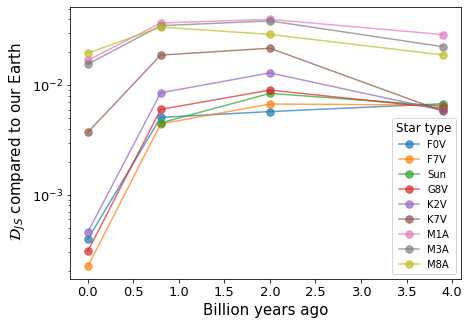

In [49]:
years = [0, 0.8, 2, 3.9]
plt.plot(years, djs_df['F0V'], label='F0V', marker='.', markersize=15, alpha=0.7)
plt.plot(years, djs_df['F7V'], label='F7V', marker='.', markersize=15, alpha=0.7)
plt.plot(years[1:], djs_df['Sun'][1:], label='Sun', marker='.', markersize=15, alpha=0.7)
plt.plot(years, djs_df['G8V'], label='G8V', marker='.', markersize=15, alpha=0.7)
plt.plot(years, djs_df['K2V'], label='K2V', marker='.', markersize=15, alpha=0.7)
plt.plot(years, djs_df['K7V'], label='K7V', marker='.', markersize=15, alpha=0.7)
plt.plot(years, djs_df['M1A'], label='M1A', marker='.', markersize=15, alpha=0.7)
plt.plot(years, djs_df['M3A'], label='M3A', marker='.', markersize=15, alpha=0.7)
plt.plot(years, djs_df['M8A'], label='M8A', marker='.', markersize=15, alpha=0.7)

plt.xlabel('Billion years ago', fontsize=15)
plt.ylabel(r' $\mathcal{D}_{JS}$ compared to our Earth', fontsize=15)

plt.yscale('log')
plt.legend(title='Star type',title_fontproperties={'size':'large'})
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.gcf().set_size_inches(7, 5)

This shows how the total $D_{JS}$ density changes with time about different stars. It is similar to the analysis we'd done with Fourier-transformed data. Again, all of the planets look most similar to Earth when they share Earth's age (with the strange exception of the K7 star system) and generally become more dissimilar to Earth as they are evolved back in time. There is also overlap in this plot, just like there was in the plot from the previous method - for instance, the $D_{JS}$ for the M and cooler stars is larger even at 0Gya than the G and hotter stars at 3.9Gya! 

We can now use this method to get the $D_{JS}$ density at different locations. I've chosen here to plot the $D_{JS}$ density as a function of (angular) wavenumber, in units of 1/$\mu$m. Note that I am using transition line labels from Exo_Transmit still, so $\textit{the molecular absorption transitions I've labeled won't perfectly match their transitions}$ in Lisa's data. This is just meant to be a demonstration.

In [50]:
#This is identical to the get_djs() method above but without the sum 
def get_djs_density(spec1):
    
    spec2 = earth
    p, q = spec1/sum(spec1), spec2/sum(spec2)
    r = 1/2 * (p+q)
    
    Djs_dens = 1/2 * p*np.log(p/r) + 1/2 * q*np.log(q/r)
    
    return Djs_dens

In [51]:
#this calculates the Djs denity of every spectrum in our dataset (about different stars & through different ages)
djs_dens_df = spectra_df.applymap(lambda spec: get_djs_density(spec))

In [54]:
#this plots absorption line (here, at wavenumber locations) labels onto a specified axis

def add_line_labels(axis):
    #absorption line locations (in inverse um)
    strong_CO = 2*np.pi/np.array([4.65])
    strong_H2O = 2*np.pi/np.array([1.45, 1.77, 2.52, 5.91, 7.60, 9.19, 13.26, 19.91])
    strong_Na = 2*np.pi/np.array([0.59])
    strong_CH4 = 2*np.pi/np.array([3.43])
    strong_K = 2*np.pi/np.array([0.40, 0.77])
    
    #how high up on y-axis to put text to label absorption line
    height = 1e-6

    #plot absorption line (here, wavenumber) labels
    for i in range(len(strong_CO)):
        axis.axvline(x=strong_CO[i], ymin = 0.7, ymax=0.9, color='black')
        axis.text(strong_CO[i], height, 'CO', fontsize='small')
    for i in range(len(strong_H2O)):
        axis.axvline(x=strong_H2O[i],ymin = 0.7, ymax=0.9, color='blue', linestyle='dashed')
        axis.text(strong_H2O[i],  height, 'H2O', fontsize='small')
    for i in range(len(strong_Na)):
        axis.axvline(x=strong_Na[i],ymin = 0.7, ymax=0.9, color='red')
        axis.text(strong_Na[i],  height, 'Na', fontsize='small')
    for i in range(len(strong_CH4)):
        axis.axvline(x=strong_CH4[i], ymin = 0.7, ymax=0.9, color='orange')
        axis.text(strong_CH4[i],  height, 'CH4', fontsize='small')
    for i in range(len(strong_K)):
        axis.axvline(x=strong_K[i], ymin = 0.7, ymax=0.9, color='teal')
        axis.text(strong_K[i],  height, 'K', fontsize='small')


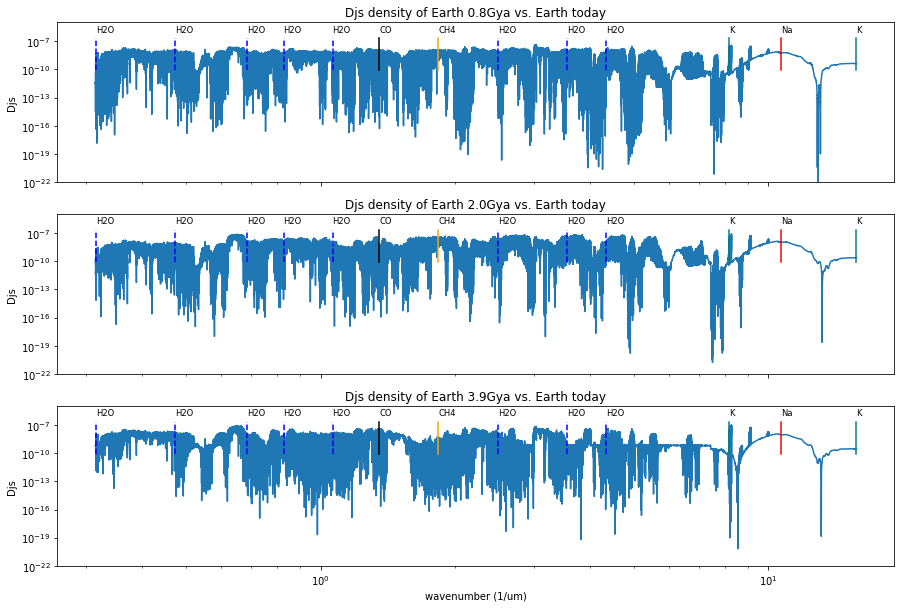

In [61]:
#this cell is plotting the spectra and their line labels

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

ax1.plot(2*np.pi/waves, djs_dens_df['Sun']['0.8Ga'], label='0.8Gya')
ax2.plot(2*np.pi/waves, djs_dens_df['Sun']['2.0Ga'], label='2.0Gya')
ax3.plot(2*np.pi/waves, djs_dens_df['Sun']['3.9Ga'], label='3.9Gya')

for ax in [ax1, ax2, ax3]:
    add_line_labels(ax)
    ax.set_ylabel('Djs')
    ax.set_ylim([1e-22, 1e-5])
    ax.set_yscale('log')
    ax.set_xscale('log')
    
ax1.set_title('Djs density of Earth 0.8Gya vs. Earth today')
ax2.set_title('Djs density of Earth 2.0Gya vs. Earth today')
ax3.set_title('Djs density of Earth 3.9Gya vs. Earth today')

ax3.set_xlabel('wavenumber (1/um)')
plt.gcf().set_size_inches(15, 10)

We have thus demonstrated how to find $D_{JS}$ density at different molecular transitions. If we go with this method, the next step is simply to get correct line labels from Lisa's data. We can apply this method to all of the star-planet systems in Lisa's dataset to find ranges of $D_{JS}$ density at various biosignature transitions for Earth-like planets about different stars and through different geological phases. This code is already written - it's just what has been shown above!

Note also that this method doesn't require us to do any linearization because the Fourier transform has already been completed. 